In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [3]:
df=pd.read_csv("C:/Users/HP/Downloads/Stock file/stock_data.csv")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


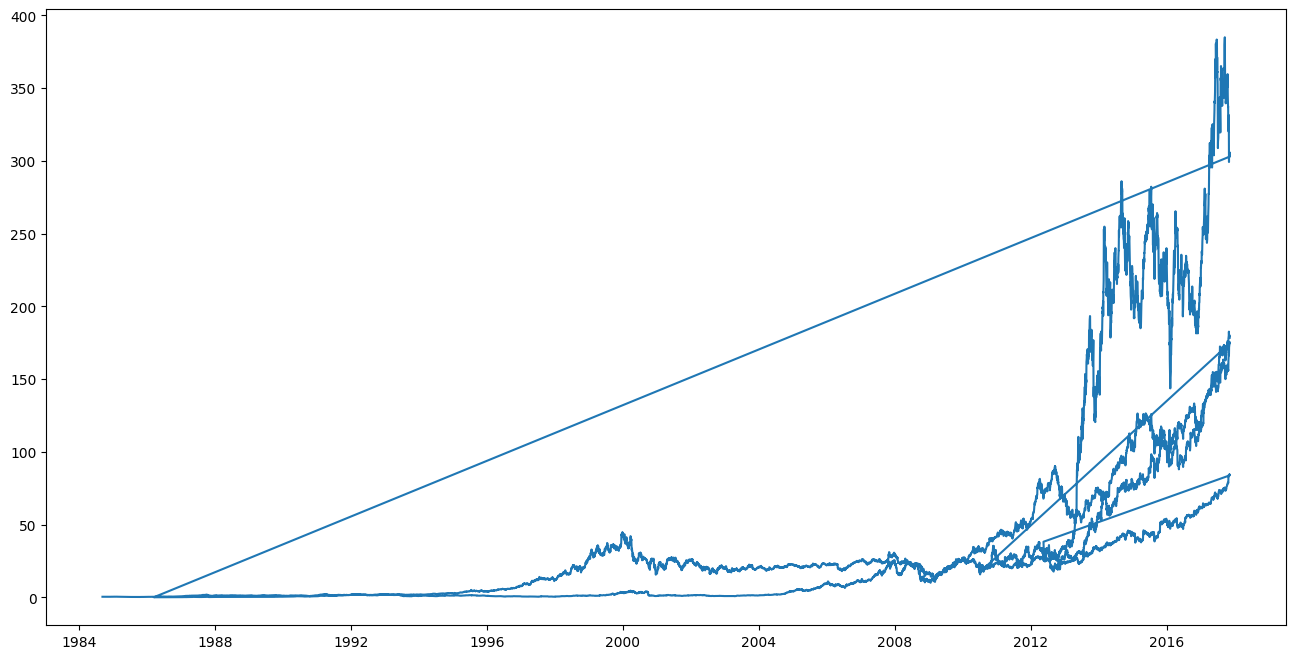

In [4]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [5]:
data = df.sort_index(ascending=True, axis=0)

new_dataset = data[[ 'Close']].reset_index(drop=True)  # Avoids explicit looping


In [6]:
new_dataset = data[['Close']].copy()  # No need for 'Date'

# ✅ Convert DataFrame to NumPy array (only numerical values)
final_dataset = new_dataset.values  

# ✅ Split into train and validation sets
train_data = final_dataset[:987, :]
valid_data = final_dataset[987:, :]

# ✅ Apply MinMaxScaler only on numerical data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_data)  

# ✅ Creating training sequences
x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])  # Past 60 days as input
    y_train_data.append(scaled_data[i, 0])  # Target value

# ✅ Convert lists to NumPy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# ✅ Reshape data for LSTM input
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [7]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 29s - 31ms/step - loss: 0.0470


In [7]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step


In [8]:
lstm_model.save("saved_model.h5")


In [10]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
app = dash.Dash()
server = app.server
scaler=MinMaxScaler(feature_range=(0,1))
df_nse = pd.read_csv("C:/Users/HP/Downloads/Stock file/stock_data.csv")
df_nse["Date"]=pd.to_datetime(df_nse.Date,format="%Y-%m-%d")
df_nse.index=df_nse['Date']
data=df_nse.sort_index(ascending=True,axis=0)
new_data=pd.DataFrame(index=range(0,len(df_nse)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_data["Date"][i]=data['Date'][i]
    new_data["Close"][i]=data["Close"][i]
new_data.index=new_data.Date
new_data.drop("Date",axis=1,inplace=True)
dataset=new_data.values
train=dataset[0:987,:]
valid=dataset[987:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
x_train,y_train=[],[]
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
model=load_model("saved_model.h5")
inputs=new_data[len(new_data)-len(valid)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)
X_test=[]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)
train=new_data[:987]
valid=new_data[987:]
valid['Predictions']=closing_price
df= pd.read_csv("./stock_data.csv")
app.layout = html.Div([
   
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
       
        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
            html.Div([
                html.H2("Actual closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'}, 
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),
         
                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])
@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure
@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure
if __name__=='__main__':
    app.run_server(debug=True)

582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
